<a href="https://colab.research.google.com/github/Abdul-ur-Rehman-Butt/2022-SE-27_LAB_TASKS_ML/blob/main/lab_12__2022_SE_27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

In [4]:
data  = pd.read_excel('/content/Online Retail.xlsx')

In [5]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
data.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [10]:
# Fill missing numerical values with 0
data.fillna({"CustomerID": data["CustomerID"].median(),  # Use median for ID
           "Description": "Unknown",  # Use 'Unknown' for missing descriptions
           "Quantity": 0,
           "UnitPrice": 0}, inplace=True)


In [11]:
# Drop rows with missing CustomerID
data_cleaned = data.dropna(subset=["CustomerID"])

In [12]:
data.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,541909.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,11476.974671
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,0.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,12352.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,14382.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16255.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,6777.908326


In [14]:
# Remove outliers using the IQR method
Q1 = data_cleaned[['Quantity', 'UnitPrice']].quantile(0.25)
Q3 = data_cleaned[['Quantity', 'UnitPrice']].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_filtered = data_cleaned[~((data_cleaned[['Quantity', 'UnitPrice']] < lower_bound) |
                           (data_cleaned[['Quantity', 'UnitPrice']] > upper_bound)).any(axis=1)]

In [15]:
# Aggregate customer purchasing behavior
customer_data = df_filtered.groupby("CustomerID").agg(
    TotalSpent=("UnitPrice", lambda x: (x * df_filtered.loc[x.index, "Quantity"]).sum()),
    TotalQuantity=("Quantity", "sum"),
    UniqueProducts=("StockCode", "nunique")
).reset_index()

In [16]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data.iloc[:, 1:])  # Exclude CustomerID

In [17]:
# Determine the optimal K using the Elbow method
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

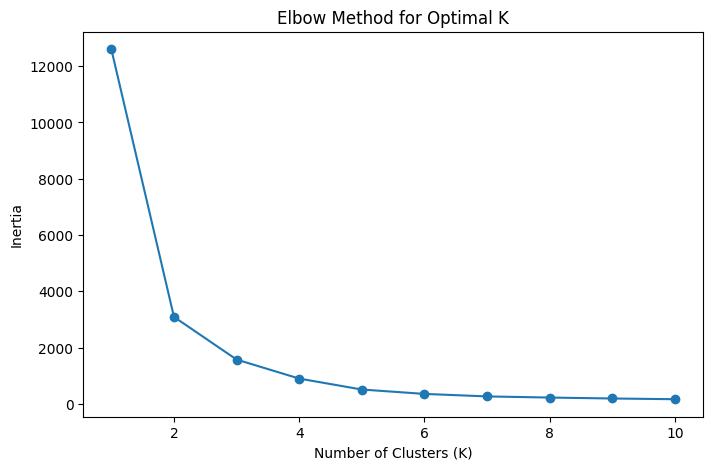

In [18]:
# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

In [19]:
# Apply K-Means clustering
optimal_k = 4  # Choose based on the Elbow Method plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_data["Cluster_KMeans"] = kmeans.fit_predict(scaled_data)

In [20]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=1.2, min_samples=5)  # Adjust eps and min_samples as needed
customer_data["Cluster_DBSCAN"] = dbscan.fit_predict(scaled_data)


In [21]:
# Compare clustering results
print("K-Means Clustering Results:")
print(customer_data["Cluster_KMeans"].value_counts())

print("\nDBSCAN Clustering Results:")
print(customer_data["Cluster_DBSCAN"].value_counts())

K-Means Clustering Results:
Cluster_KMeans
0    3684
1     510
3       5
2       1
Name: count, dtype: int64

DBSCAN Clustering Results:
Cluster_DBSCAN
 0    4193
-1       7
Name: count, dtype: int64


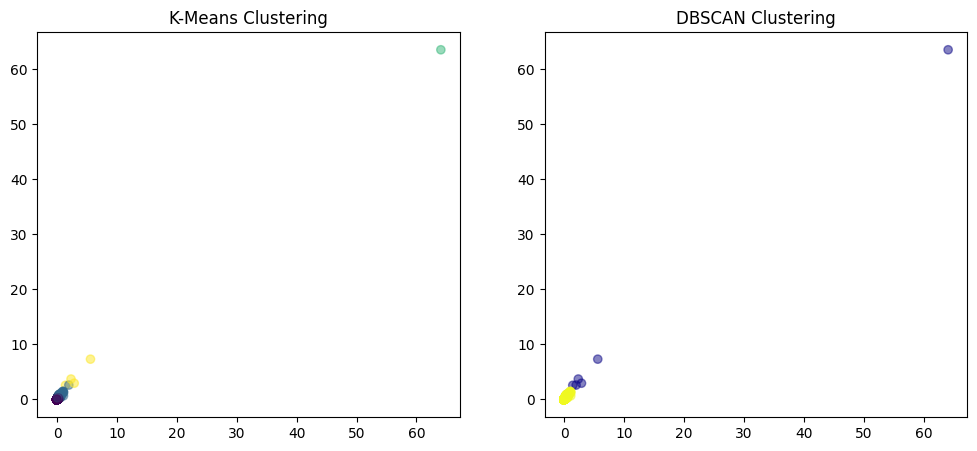

In [22]:
# Visualize the clustering results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=customer_data["Cluster_KMeans"], cmap='viridis', alpha=0.5)
plt.title("K-Means Clustering")

plt.subplot(1, 2, 2)
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=customer_data["Cluster_DBSCAN"], cmap='plasma', alpha=0.5)
plt.title("DBSCAN Clustering")

plt.show()
